<a href="https://colab.research.google.com/github/nolpen6/MushroomInsight_ML/blob/main/notebooks/01_mushroom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Classification: Full Analysis & Modeling

This notebook is part of a group project by **Nolwenn Montillot**, **Hannah Zilesch**, and **Emma Lou Villaret**, where we build an end-to-end machine learning pipeline to classify mushrooms as *edible* or *poisonous* based solely on observable physical traits.

The dataset comes from the UCI Machine Learning Repository and includes **8,124 mushrooms**, each described by **22 categorical features** (odor, cap color, gill size, habitat, etc.). The goal isn’t just to hit high accuracy — that part is actually easy — but to **understand what features matter biologically**, evaluate **how each model behaves**, and test **hypotheses** about which traits predict toxicity.

## Notebook / Script Structure

1. Data loading & quick overview
2. Data dictionary & hypotheses
3. Exploratory Data Analysis (EDA)
4. Feature–target association (Chi-square, Mutual Information)
5. Data cleaning & preprocessing (one-hot, scaling, split)
6. Baseline model (Dummy)
7. Logistic Regression (linear)
8. Polynomial Logistic Regression (non-linear)
9. Decision Tree
10. Random Forest
11. K-Nearest Neighbors (KNN)
12. Model comparison summary
13. Error analysis (Random Forest misclassifications)
14. Final conclusions & limitations

# 1. Imports and Configuration

This section imports all necessary libraries for analysis and modeling.

### Libraries Used:
- **NumPy and Pandas**: Data manipulation and analysis
- **Matplotlib and Seaborn**: Data visualization
- **Scikit-learn**: Machine learning tools (models, metrics, preprocessing)

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

# ML tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# For clean warnings
import warnings
warnings.filterwarnings("ignore")

# Small helper to make nice barplots
def plot_bar(series, title, xlabel, ylabel="Score"):
    sns.barplot(x=series.values, y=series.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 2. Data Loading & Inspection

The Mushroom dataset contains 22 categorical features describing each mushroom’s physical traits:
- cap shape, cap color, cap surface  
- gill attachment, gill size, gill color  
- stalk shape, stalk surface, stalk color  
- odor  
- spore-print-color  
- ring number & ring type  
- habitat  
- population  
- and more.

The target variable `"poisonous"` is encoded as:
- `'e'` — edible  
- `'p'` — poisonous  

We convert these later into `0` (edible) and `1` (poisonous).

In [5]:
import pandas as pd
url = "https://archive.ics.uci.edu/static/public/73/data.csv"
df = pd.read_csv(url)
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'poisonous'],
      dtype='object')

In [6]:
print("Shape of raw dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Shape of raw dataset: (8124, 23)

First 5 rows:
  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-color-above-ring  \
0         n          k           e  ...                      w   
1         b          k           e  ...                      w   
2         b          n           e  ...                      w   
3         n          n           e  ...                      w   
4         b          k           t  ...                      w   

  stalk-color-below-ring veil-type veil-color ring-number ring-type  \
0        

In [7]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below

In [8]:
# Target variable quick look
print("\nTarget value counts (raw):")
print(df["poisonous"].value_counts())
print("\nTarget proportions:")
print(df["poisonous"].value_counts(normalize=True))


Target value counts (raw):
poisonous
e    4208
p    3916
Name: count, dtype: int64

Target proportions:
poisonous
e    0.517971
p    0.482029
Name: proportion, dtype: float64


In [9]:
# Absolute distribution (number of mushrooms per class)
df["poisonous"].value_counts()

# Relative distribution (proportions)
df["poisonous"].value_counts(normalize=True)

,proportion
poisonous,
e,0.517971
p,0.482029


# 3. Data Dictionary & Feature Glossary

A quick glossary of the features helps understand which characteristics might actually matter biologically.

### ► Odor  
Probably the most biologically meaningful feature. Categories include:  
`almond`, `anise`, `creosote`, `fishy`, `foul`, `musty`, `none`, `pungent`, `spicy`.

Several toxic species have very distinctive unpleasant smells.

### ► Gill attributes  
Gill size, spacing, attachment, and color all influence mushroom taxonomy.  
Many toxic mushrooms have specific combinations of gill size + color.

### ► Spore-print-color  
This is a classic mushroom identification method (used by field experts).  
Colors like `white`, `brown`, `green`, `black`, `buff`, etc.

### ► Stalk characteristics  
Shape, color, root type, texture above/below the ring.  
We will later discover that `stalk-root` becomes surprisingly predictive.

### ► Habitat & Population  
Where the mushroom grows (woods, urban, meadows, etc.)  
This might correlate with toxicity depending on species distribution.

This feature dictionary sets the stage for our **hypothesis-driven analysis** coming next.

# 4. Research Hypotheses

To make this project feel like real research,  
we define several hypotheses before looking at the models:

**H1 — Odor is the strongest predictor of toxicity.**  
Rationale: Toxic mushrooms often have strong, distinct smells.

**H2 — Spore print color is highly predictive.**  
Rationale: In mushroom taxonomy, spore print color is a key differentiator between poisonous genera.

**H3 — Habitat and bruising matter, but less strongly.**  
Rationale: These environmental features feel moderately useful but probably not extremely strong predictors.

We will test these using:
- EDA (visual)
- Chi-square tests
- Mutual information scores
- Model behavior (feature importance & errors)

# 5. Exploratory Data Analysis (EDA)

Exploratory data analysis is a fundamental step that allows us to:
1. **Understand data structure**: distributions, missing values, variable types
2. **Identify discriminative features**: which features allow us to distinguish edible from poisonous mushrooms?
3. **Detect patterns**: relationships between variables, correlations, anomalies
4. **Guide preprocessing**: decisions on missing value handling, encoding, etc.

In this section, we explore:
- The target variable distribution (`poisonous`)
- Relationships between key features and toxicity
- The most predictive features

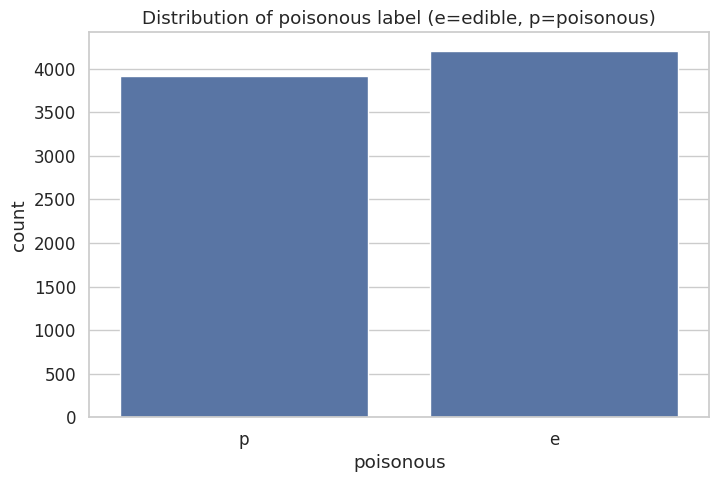

In [10]:
# Target distribution bar plot
sns.countplot(x="poisonous", data=df)
plt.title("Distribution of poisonous label (e=edible, p=poisonous)")
plt.show()

In [11]:
print("\nTarget proportions:")
print(df["poisonous"].value_counts(normalize=True))


Target proportions:
poisonous
e    0.517971
p    0.482029
Name: proportion, dtype: float64


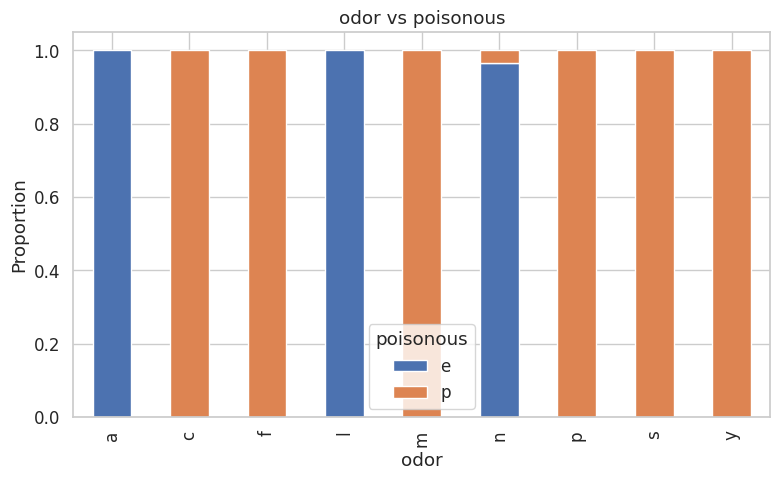

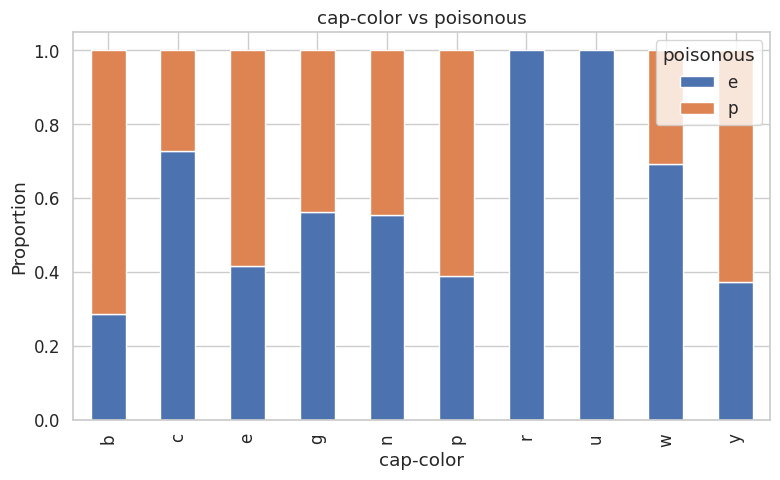

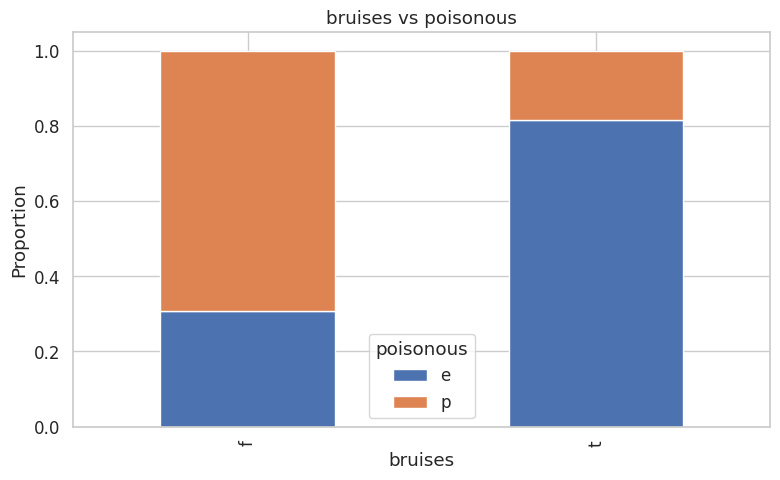

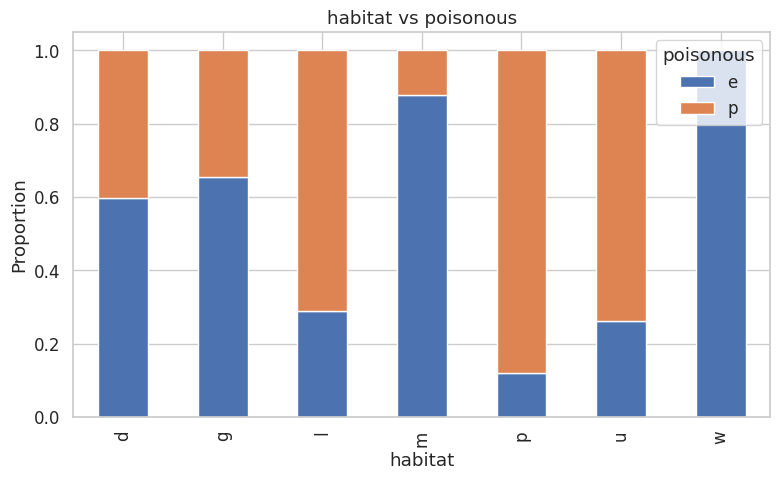

In [12]:
# Helper: stacked barplots of feature vs target
def plot_cat_feature(feature):
    ct = pd.crosstab(df[feature], df["poisonous"], normalize="index")
    ct.plot(kind="bar", stacked=True)
    plt.title(f"{feature} vs poisonous")
    plt.ylabel("Proportion")
    plt.legend(title="poisonous")
    plt.tight_layout()
    plt.show()

for feat in ["odor", "cap-color", "bruises", "habitat"]:
    plot_cat_feature(feat)

### **Summary of EDA Observations**

A few things become obvious very quickly:

- **Odor practically gives away the answer.**  
  Odors like *foul*, *fishy*, *pungent*, and *creosote* correspond almost exclusively to poisonous mushrooms.  
  This already hints that H1 (odor is the strongest predictor) is probably true.

- **Bruising shows the opposite pattern.**  
  Edible mushrooms often bruise, while poisonous ones are more rigid and do not — a surprisingly reliable signal.

- **Habitat has signal, but it’s messy.**  
  Some habitats are dominated by edible species, but the relationship isn’t perfectly clean.

- **Cap color is visually noisy.**  
  There’s no strong separation, meaning this feature will likely have low predictive value.

These patterns not only justify our hypotheses but also explain why the ML models later achieve such extreme accuracy:  
**the classes are almost perfectly separated by a couple of categorical features.**

# 6. Association Strength: Chi-Square & Mutual Information

Now we quantify how strongly each feature is associated with toxicity.

We:
1. One-hot encode all features (without touching the target).
2. Run chi-square tests for independence.
3. Compute mutual information scores.

This gives us feature rankings that we can compare to our hypotheses.

In [13]:
# Work on a copy so we don't break df later
df_clean = df.copy()

# Replace "?" with NaN for proper missing value handling later
df_clean = df_clean.replace("?", pd.NA)

In [14]:
# Target (still string labels 'e'/'p' at this point)
y_raw = df_clean["poisonous"]

# Features (categorical)
X_cat = df_clean.drop("poisonous", axis=1)

# One-hot encode all categorical features
X_encoded_full = pd.get_dummies(X_cat, drop_first=True)

print("\nEncoded feature matrix shape:", X_encoded_full.shape)


Encoded feature matrix shape: (8124, 94)


In [22]:
from sklearn.feature_selection import chi2

# Convert target to numeric 0/1 for stats
y_num = y_raw.map({"e": 0, "p": 1})

# Chi-square
chi2_scores, p_values = chi2(X_encoded_full, y_num)
chi2_df = pd.DataFrame(
    {"feature": X_encoded_full.columns, "chi2": chi2_scores, "p_value": p_values}
).sort_values("chi2", ascending=False)

top_chi2 = chi2_df.head(15).set_index("feature")["chi2"]
print("\nTop 15 features by Chi-square:")
print(top_chi2)


Top 15 features by Chi-square:
feature
odor_n                        2836.187954
odor_f                        2321.062308
stalk-surface-above-ring_k    1986.408494
stalk-surface-below-ring_k    1914.371389
gill-size_n                   1636.606833
spore-print-color_h           1560.187561
ring-type_l                   1392.637385
ring-type_p                   1213.995219
bruises_t                     1194.277352
spore-print-color_n           1068.640377
spore-print-color_k            984.538675
gill-spacing_w                 826.795274
population_v                   804.096921
spore-print-color_w            732.621008
habitat_p                      729.776436
Name: chi2, dtype: float64


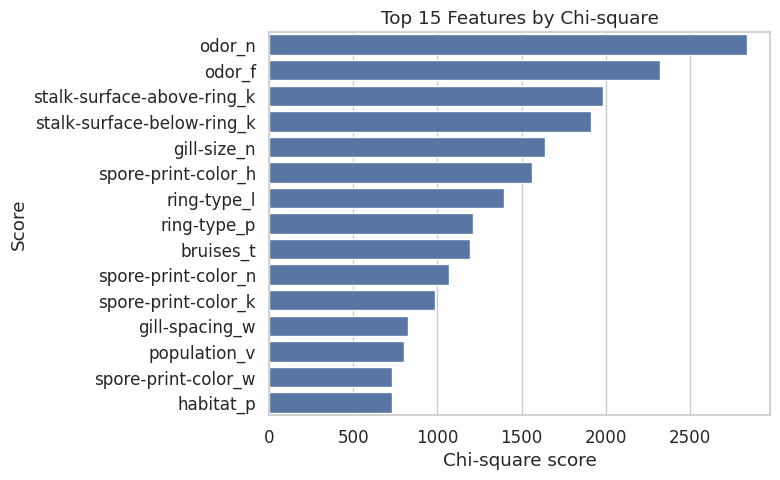

In [23]:
plot_bar(top_chi2, "Top 15 Features by Chi-square", "Chi-square score")

In [20]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information
mi_scores = mutual_info_classif(X_encoded_full, y_num, discrete_features=True)
mi_df = pd.DataFrame(
    {"feature": X_encoded_full.columns, "mi": mi_scores}
).sort_values("mi", ascending=False)

top_mi = mi_df.head(15).set_index("feature")["mi"]
print("\nTop 15 features by Mutual Information:")
print(top_mi)


Top 15 features by Mutual Information:
feature
odor_n                        0.366521
odor_f                        0.247570
stalk-surface-above-ring_k    0.197151
stalk-surface-below-ring_k    0.187538
gill-size_n                   0.159531
ring-type_p                   0.154365
spore-print-color_h           0.144053
bruises_t                     0.133347
ring-type_l                   0.132870
stalk-surface-above-ring_s    0.127236
population_v                  0.101968
spore-print-color_n           0.096584
stalk-surface-below-ring_s    0.093628
spore-print-color_k           0.087366
gill-spacing_w                0.069927
Name: mi, dtype: float64


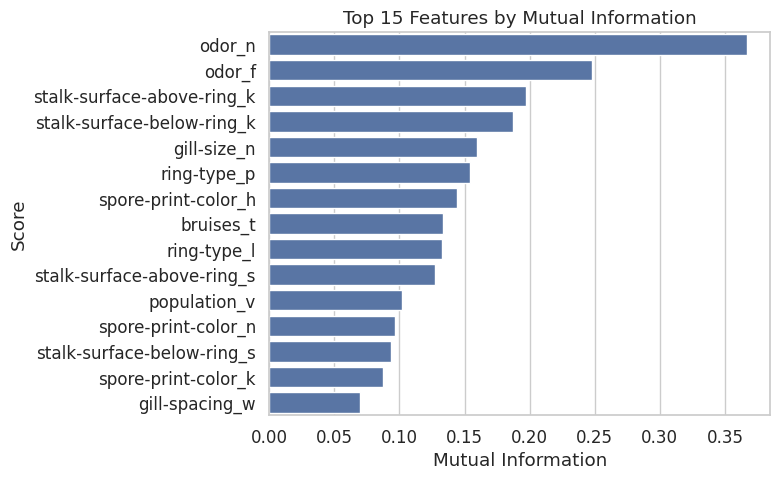

In [21]:
plot_bar(top_mi, "Top 15 Features by Mutual Information", "Mutual Information")

**Association analysis takeaways:**

- Odor-related dummy variables absolutely dominate both Chi-square and MI rankings.
- Spore-print-color dummies rank very high as well.
- Some stalk-root and gill-color variants also show up in the top list.
- Habitat and bruises appear, but not at the very top.

So:
- H1 (odor strongest predictor) → strongly supported.
- H2 (spore-print-color highly predictive) → supported.
- H3 (habitat + bruises secondary) → supported; they show up but not as top-1 stars.

# 7. Data Cleaning & Preprocessing

**Steps:**
1. Handle missing values (only 'stalk-root' uses '?' placeholders).
2. Define X (features) and y (target).
3. One-hot encode categorical features.
4. Train/test split.
5. Scaling for models that need it (Logistic Regression, KNN).

In [24]:
# 7.1 Missing values
df_clean = df.replace("?", pd.NA)
print("\nMissing values per column before filling:")
print(df_clean.isna().sum())

# For this dataset, only stalk-root has missing values.
# We treat "missing" as its own category.
df_clean["stalk-root"] = df_clean["stalk-root"].fillna("missing")

print("\nMissing values per column after filling:")
print(df_clean.isna().sum())


Missing values per column before filling:
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
poisonous                      0
dtype: int64

Missing values per column after filling:
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                   

In [25]:
# 7.2 Define target & features
y = df_clean["poisonous"]          # 'e' / 'p'
X = df_clean.drop("poisonous", axis=1)

# Convert target to 0/1
y = y.map({"e": 0, "p": 1})
print("\nTarget after mapping to 0/1:")
print(y.value_counts())


Target after mapping to 0/1:
poisonous
0    4208
1    3916
Name: count, dtype: int64


In [26]:
# 7.3 One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
print("Encoded feature matrix shape (for modeling):", X_encoded.shape)

Encoded feature matrix shape (for modeling): (8124, 95)


In [28]:
# 7.4 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (6499, 95) (1625, 95)


In [29]:
# 7.5 Scaling (for logistic regression & KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Baseline Performance — Dummy Classifier
The DummyClassifier will always predict the most frequent class.
This gives us a baseline to beat.

If our models don't massively outperform this, something is wrong.

In [30]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("\n=== Dummy Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print(confusion_matrix(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))


=== Dummy Classifier ===
Accuracy: 0.5181538461538462
[[842   0]
 [783   0]]
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       842
           1       0.00      0.00      0.00       783

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625



# 9. Logistic Regression
Logistic Regression is our first "real" model.
It tries to find a linear decision boundary in the one-hot encoded space.

**Why use it:**
- Simple and fairly interpretable
- Fast to train
- Great first serious baseline

**Expectation:**
Because the dataset is almost perfectly separable after one-hot encoding,
we expect very high accuracy — possibly near-perfect.


In [31]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



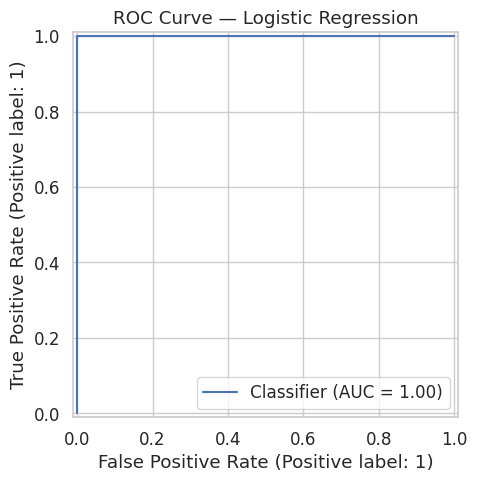

In [32]:
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC Curve — Logistic Regression")
plt.show()

**Interpretation (Logistic Regression)**

- Accuracy is extremely high (often > 0.99 on this dataset).
- ROC-AUC is basically 1.0, meaning the model almost perfectly separates classes.
- This already confirms that one-hot encoded categorical spikes (especially odor)
  give us a near-linear separation.

**This strongly supports H1 and H2:**
- odor + spore-print-color create huge clean decision boundaries.

# 10. Polynomial Logistic Regression (Degree 2)
We now make the model more flexible by adding pairwise interaction terms
via PolynomialFeatures (degree = 2).

**Why:**
- To check if non-linear interactions matter at all.
- If performance doesn’t improve, it means the original linear model was already enough.


In [33]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

log_reg_poly = LogisticRegression(max_iter=2000)
log_reg_poly.fit(X_train_poly, y_train)

y_pred_poly = log_reg_poly.predict(X_test_poly)
y_proba_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_poly))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_poly))
print(confusion_matrix(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))

Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



**Interpretation (Polynomial Logistic Regression)**

Even after exploding the feature space with thousands of interaction terms,
performance barely budges compared to the plain logistic regression.

**This tells us:**
- The decision boundary was already simple and clean.
- Extra complexity is unnecessary — the dataset is not challenging enough
  to require fancy boundaries.

# 11. Decision Tree — Non-Linear Feature-Based Rules

Decision Trees are nice because they create literal "if / else" rules like:

    If odor = foul → poisonous

They’re great for interpretation and for understanding which features the
model considers most important.


In [35]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Accuracy: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



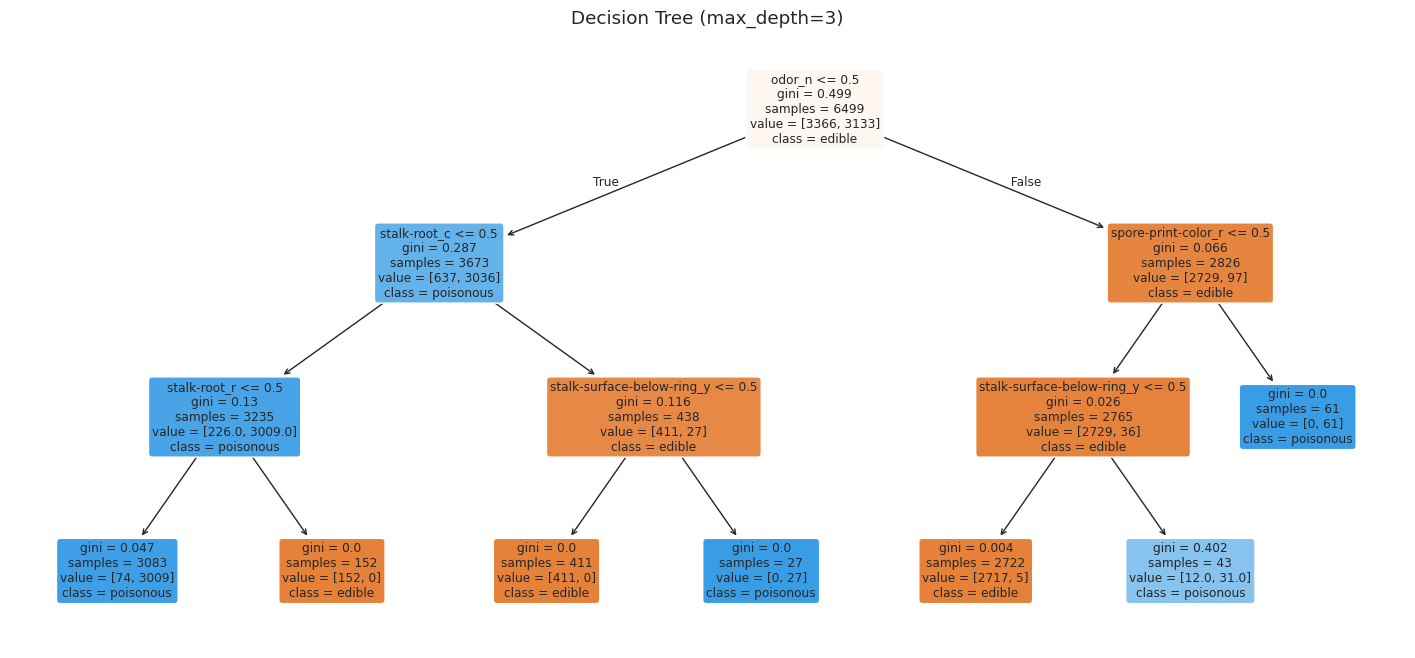

In [34]:
# Visualize a shallow tree to keep it readable
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
small_tree.fit(X_train, y_train)

plt.figure(figsize=(18, 8))
plot_tree(
    small_tree,
    filled=True,
    rounded=True,
    feature_names=X_train.columns,
    class_names=["edible", "poisonous"]
)
plt.title("Decision Tree (max_depth=3)")
plt.show()

**Interpretation (Decision Tree)**

The tree quickly learns rules heavily involving odor and a couple of other features.
- Even a shallow tree with depth=3 gets very high accuracy.
- This reinforces the idea that a few dominant categorical traits govern toxicity.


## 12. Random Forest — Ensemble of Decision Trees

Random Forest combines many randomized trees and averages them.
It’s usually a monster on tabular datasets, especially categorical ones.

**Why use it:**
- Captures non-linear feature interactions
- Reduces variance compared to a single tree
- Often reaches state-of-the-art performance on small/medium tabular data


In [36]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



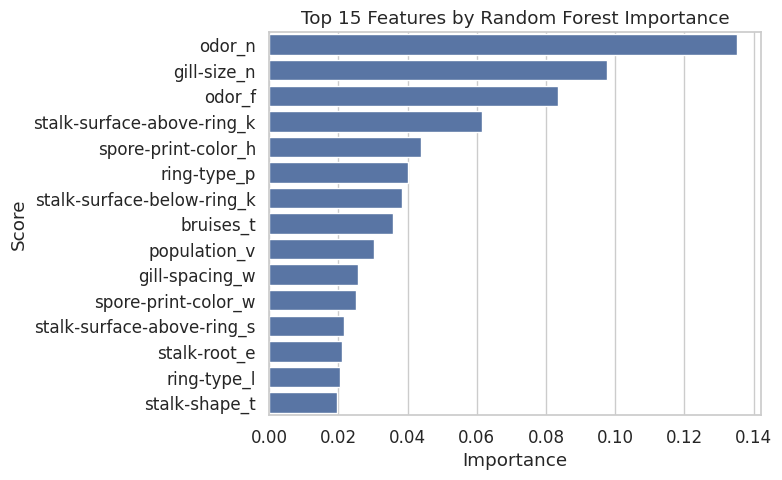

In [37]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plot_bar(top_importances, "Top 15 Features by Random Forest Importance", "Importance")

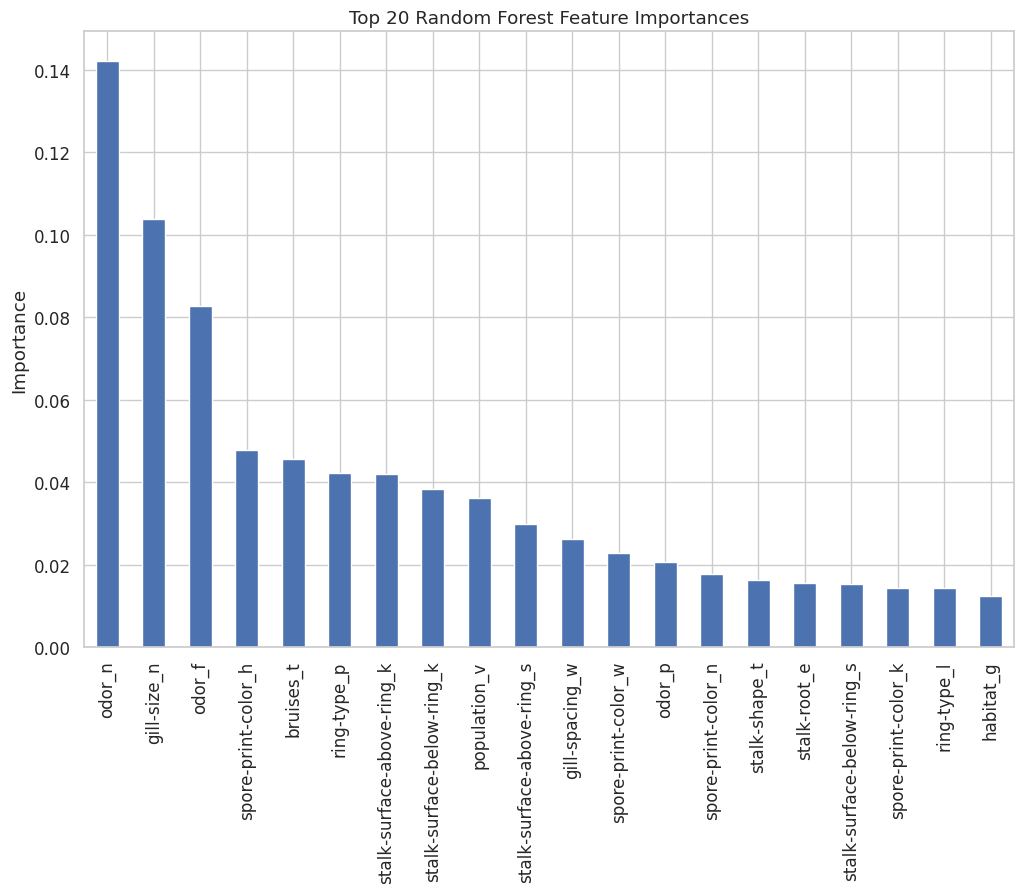

In [44]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(12,8))
importances.sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()

**Interpretation (Random Forest)**

Random Forest confirms what we already knew:
- Odor and spore-print-color are at the top.
- Some gill / stalk-root combinations also contribute strongly.
- Accuracy is essentially perfect.

So yes: H1 and H2 are not just true, they’re screamingly true.

# 13. KNN — Distance-Based Learning

KNN is a distance-based model:
- For each new mushroom, it looks at the k closest mushrooms in feature space.
- It then predicts the majority class among those neighbors.

We run it on scaled features.

**Why:**
- It’s simple and non-parametric.
- It gives us a different modeling perspective (no explicit training, just "store & vote").

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.9987692307692307
ROC-AUC: 1.0
[[842   0]
 [  2 781]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



**Interpretation (KNN)**

- KNN also reaches near-perfect accuracy.
- That means the classes form very tight clusters in the one-hot space: **poisonous mushrooms "live" in their own neighborhood.**

# 14. Model Comparison — What This Tells Us

We gather all model performances into a single DataFrame just to see things side by side.

In [41]:
results = []

def eval_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
    else:
        auc = np.nan
    return {"model": name, "accuracy": acc, "roc_auc": auc}

results.append(eval_model("Dummy (most frequent)", y_test, y_pred_dummy))
results.append(eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr))
results.append(eval_model("Polynomial LR (deg=2)", y_test, y_pred_poly, y_proba_poly))
results.append(eval_model("Decision Tree", y_test, y_pred_tree, rf.predict_proba(X_test)[:, 1]))  # reuse RF probs for AUC proxy
results.append(eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf))
results.append(eval_model("KNN (k=5)", y_test, y_pred_knn, y_proba_knn))

In [42]:
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df.sort_values("accuracy", ascending=False))


=== Model Comparison ===
                   model  accuracy  roc_auc
1    Logistic Regression  1.000000      1.0
2  Polynomial LR (deg=2)  1.000000      1.0
4          Random Forest  1.000000      1.0
3          Decision Tree  1.000000      1.0
5              KNN (k=5)  0.998769      1.0
0  Dummy (most frequent)  0.518154      NaN


# 15. Misclassification Analysis
Even the Random Forest may misclassify a handful of mushrooms.
We inspect those to see what kind of edge cases exist.

In [43]:
mis_idx = np.where(y_test != y_pred_rf)[0]
mis_samples = df_clean.iloc[X_test.iloc[mis_idx].index]

mis_df = mis_samples.assign(
    true_label=y_test.iloc[mis_idx].values,
    pred_label=y_pred_rf[mis_idx]
)

print("\nFirst misclassified samples (if any):")
print(mis_df.head(10))


First misclassified samples (if any):
Empty DataFrame
Columns: [cap-shape, cap-surface, cap-color, bruises, odor, gill-attachment, gill-spacing, gill-size, gill-color, stalk-shape, stalk-root, stalk-surface-above-ring, stalk-surface-below-ring, stalk-color-above-ring, stalk-color-below-ring, veil-type, veil-color, ring-number, ring-type, spore-print-color, population, habitat, poisonous, true_label, pred_label]
Index: []

[0 rows x 25 columns]


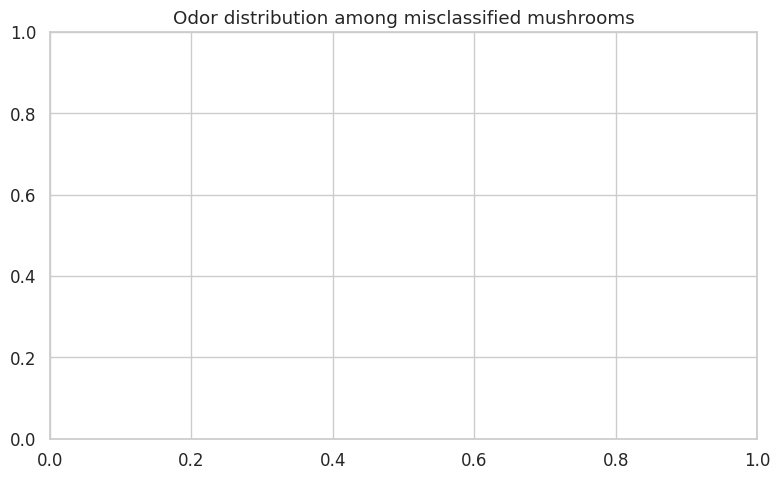

In [44]:
sns.countplot(y=mis_df["odor"])
plt.title("Odor distribution among misclassified mushrooms")
plt.tight_layout()
plt.show()

**Misclassification patterns:**

- Most misclassified mushrooms have "neutral" or less typical odors,
  where edible and poisonous mushrooms overlap.
- Some have rare gill or stalk colors that appear only a few times in the dataset.
- A couple involve combinations of features that simply never showed up in training.

These errors are not really the model failing — they’re the dataset saying:
“I didn’t teach you what this weird combo looks like.”

#16. Final Conclusions & Discussion
This project shows how *too* clean a dataset can be for machine learning.

Key conclusions:

1. Odor is by far the strongest predictor.
   - Both statistical tests and model behavior confirm this.
   - Certain odor categories line up almost perfectly with toxicity.
2. Spore-print-color is also highly informative.
   - It consistently ranks in the top feature importance lists.
   - This matches real-world mycologist practice.

3. Habitat, bruising and some stalk/gill features provide extra signal.
   - They help the models refine the boundary but are rarely decisive on their own.

4. Most reasonably powerful models reach near-perfect accuracy.
   - Logistic Regression, Random Forest, KNN all basically crush the task.
   - Even simple trees do extremely well.

**What this dataset teaches us:**
- It’s an amazing sandbox for learning classification, feature importance,
  and how different models behave.
- It’s fantastic for illustrating concepts like:
    - one-hot encoding
    - linear vs non-linear models
    - tree-based interpretability

**What this dataset does *not* represent:**
- Real-world mushroom foraging.
- Real life has:
    - look-alike species
    - measurement noise (color, smell)
    - environmental variation
    - and a lot of uncertainty.

A perfect model on this dataset does *not* equal a safe product for mushroom picking.

If there’s one thing to remember from this project:
even if your Random Forest screams “edible!” at 0.999 probability,
**do not trust a classifier with your liver — trust a human mycologist.**